In [1]:
import json
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
data_path = os.path.join('..', 'data', 'training', '0a938d79.json')

with open(data_path, 'r') as f:
  data = json.load(f)

In [3]:
def pad_data_to_30x30(data):
    # Convert input to numpy array if it's not already
    data = np.array(data)
    
    # Initialize a 30x30 array filled with -1
    padded_data = np.full((30, 30), -1, dtype=int)
    
    # Copy data to padded_data
    rows, cols = data.shape
    padded_data[:rows, :cols] = data[:30, :30]
    
    return padded_data

def visualize_grid(data):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    if data.ndim != 2:
        raise ValueError("Input must be a 2D array")
    
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.suptitle("Visualization of 2D Padded Data", fontsize=16)
    
    # Create a custom colormap
    cmap = plt.cm.get_cmap('tab10')
    colors = [cmap(i) for i in range(10)]
    custom_cmap = plt.cm.colors.ListedColormap(['lightgrey'] + colors + ['darkred'])
    
    # Create bounds and norm for the colormap
    bounds = list(range(-2, 11))  # This creates [-2, -1, 0, 1, ..., 10]
    norm = plt.cm.colors.BoundaryNorm(bounds, custom_cmap.N)
    
    im = ax.imshow(data, cmap=custom_cmap, norm=norm, interpolation='nearest')
    ax.set_title("Padded Grid")
    
    # Add grid lines
    ax.set_xticks(np.arange(-0.5, 30, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 30, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add a colorbar
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_ticks(range(-1, 11))
    cbar.set_ticklabels(['-1 (pad)'] + list(range(10)) + ['10+'])
    
    plt.tight_layout()
    plt.show()


def encode_grid(grid):
    """Convert a 2D grid to a 11-channel 3D tensor."""
    encoded = np.zeros((11, 30, 30), dtype=np.float32)
    for i in range(30):
        for j in range(30):
            value = grid[i, j]
            if -1 <= value <= 9:
                encoded[value + 1, i, j] = 1
    return encoded

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

class EnhancedMultiChannelCNN(nn.Module):
    def __init__(self, num_residual_blocks=3):
        super(EnhancedMultiChannelCNN, self).__init__()
        self.conv1 = nn.Conv2d(11, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_residual_blocks)]
        )
        
        self.conv_final = nn.Conv2d(64, 11, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.residual_blocks(x)
        x = self.conv_final(x)
        return x

In [5]:
X = torch.tensor([encode_grid(pad_data_to_30x30(ex['input'])) for ex in data['train']])
Y = torch.tensor([encode_grid(pad_data_to_30x30(ex['output'])) for ex in data['train']])

<ipython-input-5-900f5a4509ec>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X = torch.tensor([encode_grid(pad_data_to_30x30(ex['input'])) for ex in data['train']])


In [6]:
dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
model = EnhancedMultiChannelCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [8]:
num_epochs = 10000
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.argmax(dim=1))
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1000/10000], Loss: 0.0009
Epoch [2000/10000], Loss: 0.0006
Epoch [3000/10000], Loss: 0.0005


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'linear_static_dictionary.pth')

In [19]:
def predict(input_data):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(encode_grid(pad_data_to_30x30(input_data))).unsqueeze(0)
        output = model(input_tensor)
        return output.argmax(dim=1).squeeze().numpy() - 1  # Convert back to [-1, 9] range
    
# Function to visualize prediction
def visualize_prediction(input_data):
    predicted_output = predict(input_data)
    visualize_grid(predicted_output)

def visualize_actual(data):
    visualize_grid(pad_data_to_30x30(data['output']))
    visualize_prediction(pad_data_to_30x30(data['input']))


/var/folders/0c/jz9xl1bn1l76cln4b1_92qcm0000gn/T/ipykernel_2606/3092285205.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab10')


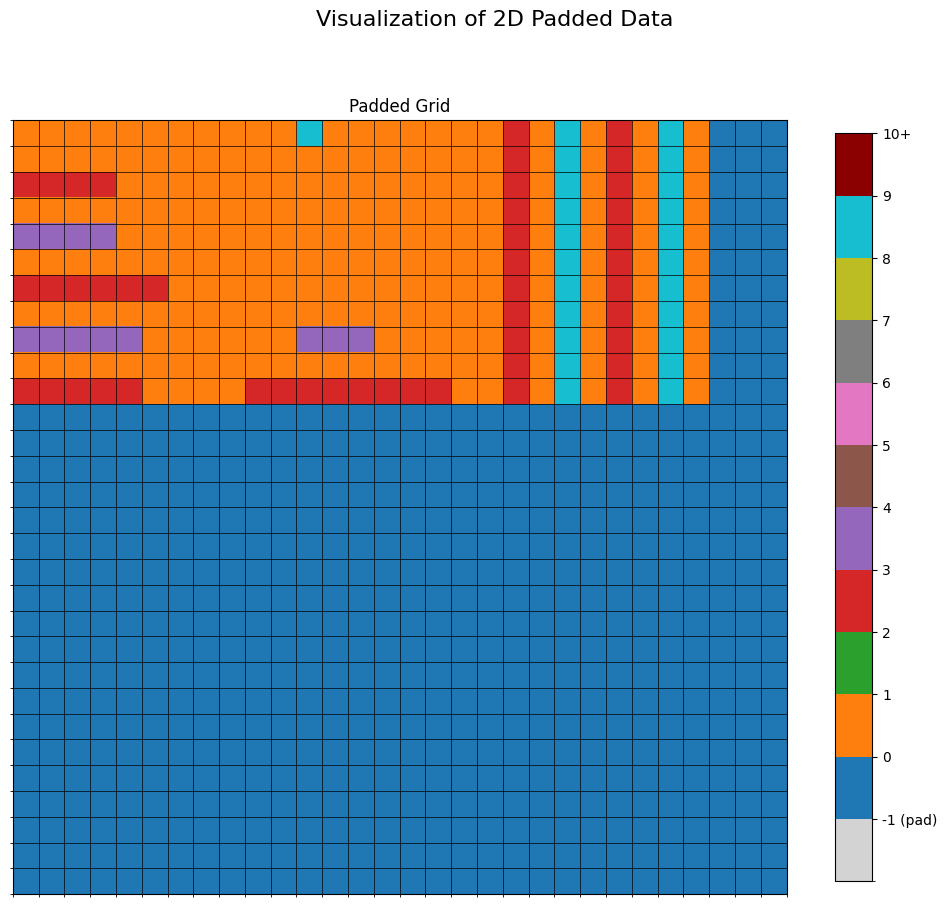

In [42]:
test_input = data['test'][0]['input']
visualize_actual(data['test'][0])
visualize_prediction(test_input)
